# Build a Multi-Layer Perceptron from scratch

##### Louis Salomé

Mostly inspired from a code written by Bernd Klei found with this link : https://www.python-course.eu/neural_networks_with_python_numpy.php

My personal work in this notebook is :
* comment the code
* force the use of a bias nodes
* add a batch size argument to use mini batch strategy
* add a method for a tuning number of epochs and plot training error
* add a method for computing a score on a test set
* test it on MNIST Dataset
* add a second hidden layer !

In the last part of this notebook is a GUI that enables you to draw a digit with your mouse in a window and see if your neural network can guess it.

In [2]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

In [3]:
@np.vectorize # decorator to vectorize the result
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
activation_function = sigmoid

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

## 1. A 1-hidden layer perceptron

In [5]:
class myMLP:
            
    def __init__(self, n_in, n_out, n_hidden, learning_rate):  
        self.n_in = n_in                   # number of input nodes
        self.n_out = n_out                 # number of output nodes
        self.n_hidden = n_hidden           # number of hidden nodes in the first layer
        self.learning_rate = learning_rate # learning rate
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural 
        network with optional bias nodes"""

        # initialise weights between in and hidden
        rad = 1 / np.sqrt(self.n_in + 1)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden = X.rvs((self.n_hidden, self.n_in + 1))
        
        # initialise weights between hidden and out
        rad = 1 / np.sqrt(self.n_hidden + 1)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_out = X.rvs((self.n_out, self.n_hidden + 1))
        
        
        
    def learn_one_batch(self, input_vector, target_vector):
        
        ################ FEED FORWARD #################
        # hidden layer
        output_vector1 = np.dot(self.weights_in_hidden, input_vector)
        output_vector_hidden = activation_function(output_vector1)
        # add offset for bias node    
        output_vector_hidden = np.concatenate(
            (output_vector_hidden, np.ones((1,output_vector_hidden.shape[1]))) , axis=0)
        
        # output layer
        output_vector2 = np.dot(self.weights_hidden_out, output_vector_hidden)
        output_vector_network = activation_function(output_vector2)
        ###############################################
    
        
        ############### BACKPROPAGATION ###############
        # hidden // output 
        output_errors = target_vector - output_vector_network
        tmp = output_errors * output_vector_network * (1.0 - output_vector_network) 
        tmp = self.learning_rate  * np.dot(tmp, output_vector_hidden.T)
        self.weights_hidden_out += tmp
        
        # input // hidden
        hidden_errors = np.dot(self.weights_hidden_out.T, output_errors)
        tmp = hidden_errors * output_vector_hidden * (1.0 - output_vector_hidden)
        tmp = np.dot(tmp, input_vector.T)[:-1,:]
        self.weights_in_hidden += self.learning_rate * tmp
        ###############################################
        
        # get training error for plotting
        acc = ( np.argmax(output_vector_network,axis=0)
               == np.argmax(target_vector,axis=0)       ).sum() / target_vector.shape[1]
        return acc
        
    
    def train(self,input_vector, target_vector,epochs = 1000,verbose=0,batch_size = 128):
        
        # adding offset to input data as bias node
        input_vector = np.concatenate( (input_vector, np.ones((input_vector.shape[0],1))) , axis=1)
                                    
        # Check dimensions
        assert input_vector.ndim == 2, "Wrong input_vector dimension"
        assert target_vector.ndim == 2, "Wrong target_vector dimension"
        
        # plot training error
        errs = []
        
        for epoch in range(epochs):
            # define a batch for this epoch
            index = np.random.randint(input_vector.shape[0], size=batch_size)
            acc = self.learn_one_batch(input_vector[index].T, target_vector[index].T)
            # store training error
            errs.append(1-acc)

            if verbose == 1:
                print("epoch :",epoch,"err",1-acc)
        print("Training complete !",epochs,"epochs done.")
        
        plt.plot(errs)
        plt.title("Training error")
        plt.xlabel("Epochs")
        plt.ylabel("Training error")
        plt.grid(True)
        plt.show()
        pass

        
    def run(self, input_vector):
        
        # adding bias node to the end of the input_vector
        input_vector = np.concatenate( (input_vector, np.ones((input_vector.shape[0],1))) , axis=1)
        input_vector = np.array(input_vector, ndmin=2).T
        
        ################ FEED FORWARD #################
        output_vector = np.dot(self.weights_in_hidden, input_vector)
        output_vector = activation_function(output_vector)
        output_vector = np.concatenate( (output_vector, np.ones((1,output_vector.shape[1]))) , axis=0)
            
        output_vector = np.dot(self.weights_hidden_out, output_vector)
        output_vector = activation_function(output_vector)
        ###############################################
    
        return output_vector
    
    def score(self,input_vector,target_vector):
        output_vector = self.run(input_vector)
        predict_vector = np.argmax(output_vector,axis=0)
        return (predict_vector == target_vector).sum() / target_vector.size
    

Training complete ! 1500 epochs done.


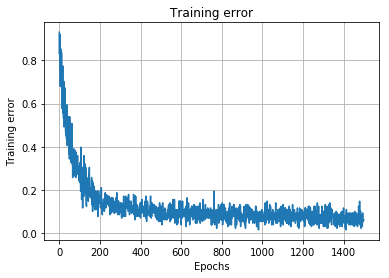

Accuracy :  92.98 %
Wall time: 34.1 s


In [8]:
%%time

# import dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X, y = mnist.data, mnist.target
X, y = X.astype('float32'), y.astype('float32')
X /= 255

# split train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# use one hot encoder
from sklearn.preprocessing import OneHotEncoder
def one_hot(y):
    enc = OneHotEncoder()
    enc.fit(y.reshape(-1,1))
    return enc.transform(y.reshape(-1,1)).toarray()

# initialise classifier
m,n = X_train.shape
mlp = myMLP(n_in = n, n_out = 10, n_hidden = 64, learning_rate=0.007)

# train
mlp.train(X_train,one_hot(y_train),epochs=1500,verbose=0, batch_size = 128)

# score
print("Accuracy : ",round(100*mlp.score(X_test,y_test),2),'%')

## 2. Two hidden layers

In [10]:
class myMLP:
            
    def __init__(self, n_in, n_out, n_hidden_1, n_hidden_2, learning_rate):  
        self.n_in = n_in                   # number of input nodes
        self.n_out = n_out                 # number of output nodes
        self.n_hidden_1 = n_hidden_1       # number of hidden nodes in the first hidden layer
        self.n_hidden_2 = n_hidden_2       # number of hidden nodes in the second hidden layer
        self.learning_rate = learning_rate # learning rate
        self.create_weight_matrices()
        
    def create_weight_matrices(self):
        """ A method to initialize the weight matrices of the neural 
        network with optional bias nodes"""

        # initialise weights between in and hidden_1
        rad = 1 / np.sqrt(self.n_in + 1)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_in_hidden_1 = X.rvs((self.n_hidden_1, self.n_in + 1))
        
        # initialise weights between hidden_1 and hidden_2
        rad = 1 / np.sqrt(self.n_hidden_1 + 1)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_1_hidden_2 = X.rvs((self.n_hidden_2, self.n_hidden_1 + 1))
        
        # initialise weights between hidden and out
        rad = 1 / np.sqrt(self.n_hidden_2 + 1)
        X = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        self.weights_hidden_2_out = X.rvs((self.n_out, self.n_hidden_2 + 1))
        
        
        
    def learn_one_batch(self, input_vector, target_vector):
        
        ################ FEED FORWARD #################
        # first transitions
        output_vector_hidden_1 = np.dot(self.weights_in_hidden_1, input_vector)
        output_vector_hidden_1 = activation_function(output_vector_hidden_1)
        output_vector_hidden_1 = np.concatenate( (output_vector_hidden_1, np.ones((1,output_vector_hidden_1.shape[1]))) , axis=0)
        
        # second transitions
        output_vector_hidden_2 = np.dot(self.weights_hidden_1_hidden_2, output_vector_hidden_1)
        output_vector_hidden_2 = activation_function(output_vector_hidden_2)
        output_vector_hidden_2 = np.concatenate( (output_vector_hidden_2, np.ones((1,output_vector_hidden_2.shape[1]))) , axis=0)
        
        # last transitions
        output_vector_network = np.dot(self.weights_hidden_2_out, output_vector_hidden_2)
        output_vector_network = activation_function(output_vector_network)
        ###############################################
        
        ############### BACKPROPAGATION ###############
        # HIDDEN_2 // OUT
        output_errors   = target_vector - output_vector_network
        tmp             = output_errors * output_vector_network * (1.0 - output_vector_network)
        self.weights_hidden_2_out      += self.learning_rate * np.dot(tmp,   output_vector_hidden_2.T)

        # HIDDEN_1 // HIDDEN_2
        hidden_errors_2 = np.dot(self.weights_hidden_2_out.T, output_errors)
        tmp             = hidden_errors_2 * output_vector_hidden_2 * (1.0 - output_vector_hidden_2) 
        self.weights_hidden_1_hidden_2 += self.learning_rate * np.dot(tmp, output_vector_hidden_1.T)[:-1,:]
        
        # IN // HIDDEN_1
        hidden_errors_1 = np.dot(self.weights_hidden_1_hidden_2.T, hidden_errors_2[:-1,:]) #bias
        tmp             = hidden_errors_1 * output_vector_hidden_1 * (1.0 - output_vector_hidden_1)
        self.weights_in_hidden_1        += self.learning_rate * np.dot(tmp, input_vector.T)[:-1,:] 
        ###############################################
        
        acc = (np.argmax(output_vector_network,axis=0) 
               == np.argmax(target_vector,axis=0)    ).sum() / target_vector.shape[1]
        return acc
        
    
    def train(self,input_vector, target_vector,epochs = 1000,verbose=0,batch_size = 128):
        
        # adding bias node to the end of the input_vector
        input_vector = np.concatenate( (input_vector, np.ones((input_vector.shape[0],1))) , axis=1)
        
        # Check dimensions
        assert input_vector.ndim == 2, "Wrong input_vector dimension"
        assert target_vector.ndim == 2, "Wrong target_vector dimension"
        
        # plot training error
        errs = []
        
        for epoch in range(epochs):
            # define a batch for this epoch
            index = np.random.randint(input_vector.shape[0], size=batch_size)
            acc = self.learn_one_batch(input_vector[index].T, target_vector[index].T)
            # store training error
            errs.append(1-acc)

            if verbose == 1:
                print("epoch :",epoch,"err",1-acc)
                
        print("Training complete !",epochs,"epochs done.")
        
        plt.plot(errs)
        plt.title("Training error")
        plt.xlabel("Epochs")
        plt.ylabel("Training error")
        plt.grid(True)
        plt.show()
        pass

        
    def run(self, input_vector):
        
        # adding bias node to the end of the input_vector
        input_vector = np.concatenate( (input_vector, np.ones((input_vector.shape[0],1))) , axis=1)
        input_vector = np.array(input_vector, ndmin=2).T
        
        ################ FEED FORWARD #################
        # first transitions
        output_vector = np.dot(self.weights_in_hidden_1, input_vector)
        output_vector = activation_function(output_vector)
        output_vector = np.concatenate( (output_vector, np.ones((1,output_vector.shape[1]))) , axis=0)
        
        # second transitions
        output_vector = np.dot(self.weights_hidden_1_hidden_2, output_vector)
        output_vector = activation_function(output_vector)
        output_vector = np.concatenate( (output_vector, np.ones((1,output_vector.shape[1]))) , axis=0)
        
        # last transitions
        output_vector = np.dot(self.weights_hidden_2_out, output_vector)
        output_vector = activation_function(output_vector)
        ###############################################

        return output_vector
    
    def score(self,input_vector,target_vector):
        output = self.run(input_vector)
        predict_vector = np.argmax(output,axis=0)
        return (predict_vector == target_vector).sum() / target_vector.size
    

Training complete ! 4000 epochs done.


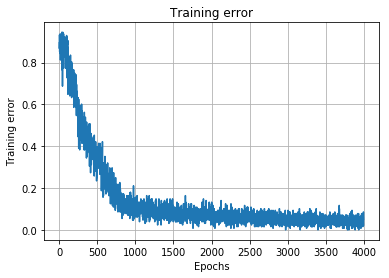

Accuracy :  95.09 %
Wall time: 1min 51s


In [11]:
%%time

# import dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X, y = mnist.data, mnist.target
X, y = X.astype('float32'), y.astype('float32')
X /= 255

# split train & test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# use one hot encoder
from sklearn.preprocessing import OneHotEncoder
def one_hot(y):
    enc = OneHotEncoder()
    enc.fit(y.reshape(-1,1))
    return enc.transform(y.reshape(-1,1)).toarray()

# initialise classifier
m,n = X_train.shape
mlp = myMLP(n_in = n, n_out = 10, n_hidden_1 = 100, n_hidden_2 = 20, learning_rate=0.005)

# train
mlp.train(X_train,one_hot(y_train),epochs=4000,verbose=0, batch_size = 128)

# score
print("Accuracy : ",round(100*mlp.score(X_test,y_test),2),'%')

## 3. GUI : draw your digit

With this cell, you can draw your digit, save it and then ask your neural network a prediction. The erase button enables you to restart.

Pressed 'predict' button :


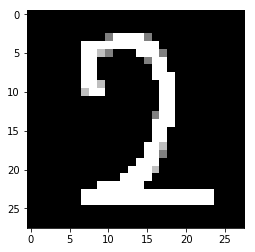

Number predicted : 2


*********************
Pressed 'predict' button :


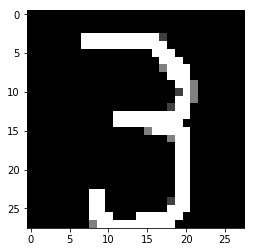

Number predicted : 3


*********************
Pressed 'predict' button :


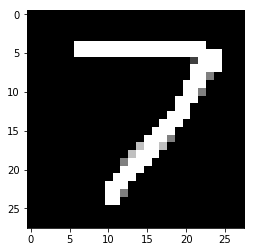

Number predicted : 7


*********************


In [28]:
from tkinter import *
from PIL import Image

import skimage as ski
import skimage.io as ski_io
from skimage.transform import rescale

# define properties of the window and the of the pen
margin = 10
canvas_height = margin+margin+28*12
canvas_width = canvas_height + 250
width_brush = 18

# event : draw a pixel
def paint( event ):
    x1, y1 = ( event.x - 1 ), ( event.y - 1 )
    x2, y2 = ( event.x + width_brush ), ( event.y + width_brush )
    #print("mouse detected on pixel (",x1,",",x2,")")
    if (x1>=10 and x1<canvas_height-margin - width_brush and
        y1>=10 and y1<canvas_height-margin -width_brush):
        w.create_rectangle( x1, y1, x2, y2, fill = "black")

# erase prediction and drawing
def erase( event=None ):
    w.create_rectangle( margin,margin,canvas_height-margin,canvas_height-margin,fill="white")
    v.set('') 

# save your drawn picture
def save( event = None ):
    w.update()
    ps = w.postscript(x=10,
                      y=10,
                      width = canvas_height-10,
                      height = canvas_height-10,
                      colormode='mono'
                      ,file = "src/task4/digit.ps"
                     )

# ask your nn a prediction
def predict():
    # read image
    img=ski_io.imread('src/task4/digit.ps')
    # convert RGB to grayscale
    img = img.mean(axis=2)
    # crop margin (and get a shape of 28*(k,k))
    margin = int((260 - 28*8)/2)
    img = img[margin:-margin,margin:-margin]
    # rescale image
    img = ski.transform.rescale(img, 1.0 / 8.0, mode = 'constant', order=1)
    # invert color
    img = 255-img
    
    img = np.array([img.reshape((784,))/255])
    prediction = np.argmax(mlp.run(img))
    v.set("This number is a "+str(prediction))
    
    print("Pressed 'predict' button :")
    plt.imshow(img.reshape((28,28)),cmap='gray')
    plt.show()
    print("Number predicted :",prediction)
    print("\n\n*********************")

master = Tk()
master.title( "Draw a digit" )
w = Canvas(master, width=canvas_width, height=canvas_height)
w.pack(expand = YES, fill = BOTH)

w.create_rectangle( margin,margin,canvas_height-margin,canvas_height-margin,fill="white")
w.bind( "<B1-Motion>", paint )

button_save = Button(master, text="save", width = 28, height = 1, command=save)
button_save.place(relx=(canvas_height + margin)/canvas_width, rely=(margin)/canvas_height)

# button_display = Button(master, text="display", width = 28,height = 1, command=display)
# button_display.place(relx=(canvas_height + margin)/canvas_width, rely=(margin + 40)/canvas_height)

button_predict = Button(master, text="predict", width = 28,height = 1, command=predict)
button_predict.place(relx=(canvas_height + margin)/canvas_width, rely=(margin + 40)/canvas_height)

button_erase = Button(master, text="erase", width = 28,height = 1, command=erase)
button_erase.place(relx=(canvas_height + margin)/canvas_width, rely=(canvas_height - 28 - margin)/canvas_height)

v = StringVar()
label_prediction = Label(master, textvariable=v)
label_prediction.place(relx=(canvas_height + margin)/canvas_width, rely=(margin + 80)/canvas_height)

mainloop()